In [1]:
## import dependecies
import os
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn as skl
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd
# import seaborn as sns
import tensorflow as tf

In [2]:
path = os.path.join(os.getcwd(), 'Resources', 'all_city_data.csv')
df = pd.read_csv(path)

In [3]:
df = df.drop(columns = {"Unnamed: 0"})
df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,dt
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,2013-01-03 00:00:00
1,9.0,9.0,3.0,17.0,300.0,89.0,-0.5,1024.5,-21.4,0.0,2013-01-03 00:00:00
2,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,2013-01-03 00:00:00
3,7.0,7.0,3.0,2.0,100.0,91.0,-2.3,1020.3,-20.7,0.0,2013-01-03 00:00:00
4,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,0.0,2013-01-03 00:00:00


In [4]:
df['dt'] = pd.to_datetime(df['dt'])

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM2.5,367284.0,78.992137,78.607575,2.0000,21.0,55.0,110.0,844.0
PM10,367284.0,104.433660,89.908912,2.0000,37.0,83.0,145.0,999.0
SO2,367284.0,15.508788,21.368411,0.2856,2.0,7.0,19.0,500.0
NO2,367284.0,50.344687,34.745149,2.0000,23.0,43.0,70.0,290.0
CO,367284.0,1215.617411,1122.181647,100.0000,500.0,900.0,1500.0,10000.0
O3,367284.0,58.005149,57.421619,0.2142,10.0,45.0,83.0,1071.0
TEMP,367284.0,14.077551,11.285307,-19.9000,4.0,15.3,23.5,41.6
PRES,367284.0,1010.339889,10.328444,982.4000,1002.1,1009.8,1018.3,1042.8
DEWP,367284.0,3.120514,13.604614,-43.4000,-8.0,4.1,15.4,29.1
RAIN,367284.0,0.067670,0.840393,0.0000,0.0,0.0,0.0,72.5


In [6]:
# df = df.groupby(pd.Grouper(key='dt', axis=0, freq='h')).mean().dropna().reset_index()

In [7]:
# df_2 = df.groupby(pd.Grouper(key='dt', axis=0, freq='D')).mean().dropna().reset_index()

## Scale the Data

In [8]:
features = ["PM10", "SO2", "NO2", "CO", "O3", "TEMP", "PRES", "DEWP", "RAIN"]
scalar = StandardScaler()
# the fit_transform ops returns a 2d numpy.array, we cast it to a pd.DataFrame
standardized_features = pd.DataFrame(scalar.fit_transform(df[features].copy()), columns = features)
old_shape = df.shape
# drop the unnormalized features from the dataframe
df.drop(features, axis = 1, inplace = True)
# join back the normalized features
df = pd.concat([df, standardized_features], axis= 1)
assert old_shape == df.shape, "something went wrong!"

In [9]:
# features = ["PM10", "SO2", "NO2", "CO", "O3", "TEMP", "PRES", "DEWP", "RAIN"]
# scalar = StandardScaler()
# # the fit_transform ops returns a 2d numpy.array, we cast it to a pd.DataFrame
# standardized_features = pd.DataFrame(scalar.fit_transform(df_2[features].copy()), columns = features)
# old_shape = df_2.shape
# # drop the unnormalized features from the dataframe
# df_2.drop(features, axis = 1, inplace = True)
# # join back the normalized features
# df_2 = pd.concat([df_2, standardized_features], axis= 1)
# assert old_shape == df_2.shape, "something went wrong!"

In [10]:
df.head()

,PM2.5,dt,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN
0,4.0,2013-01-03,-1.117062,-0.538590,-1.247505,-0.815927,0.330797,-1.309452,1.225754,-1.611258,-0.080522
1,9.0,2013-01-03,-1.061450,-0.585388,-0.959695,-0.815927,0.539777,-1.291730,1.370984,-1.802370,-0.080522
2,4.0,2013-01-03,-1.117062,-0.070608,-0.873352,-0.815927,0.191476,-1.309452,1.225754,-1.611258,-0.080522
3,7.0,2013-01-03,-1.083694,-0.585388,-1.391410,-0.994152,0.574608,-1.451230,0.964339,-1.750917,-0.080522
4,5.0,2013-01-03,-1.005838,-0.538590,-1.103600,-0.905040,0.470117,-1.291730,1.370984,-1.802370,-0.080522


In [11]:
# df_2.head()

In [12]:
# df=df.groupby(pd.Grouper(key='dt', axis=0, freq='D')).mean().dropna().reset_index()
# df.head()

(-1.0, 1.0)

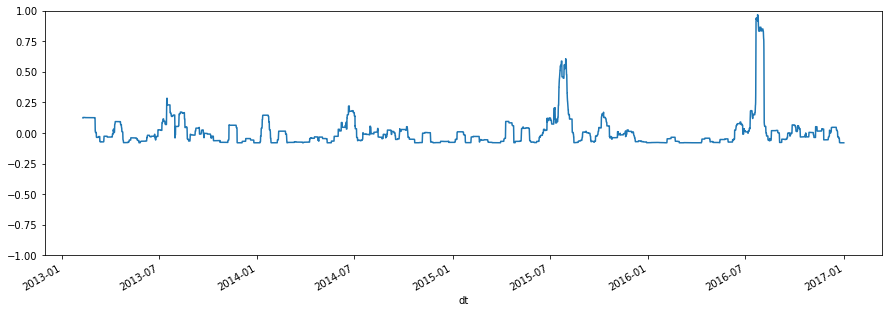

In [13]:
import matplotlib.pyplot as plt
df.groupby('dt').mean()['RAIN'].rolling(365).mean().plot(figsize=(15, 5))
plt.ylim(-1, 1)

## Create Machine Learning Model for PM2.5

In [14]:
time_index=pd.to_datetime(df['dt'])
df_kl=df.set_index(time_index)
df_kl.index

DatetimeIndex(['2013-01-03 00:00:00', '2013-01-03 00:00:00',
               '2013-01-03 00:00:00', '2013-01-03 00:00:00',
               '2013-01-03 00:00:00', '2013-01-03 00:00:00',
               '2013-01-03 00:00:00', '2013-01-03 00:00:00',
               '2013-01-03 00:00:00', '2013-01-03 00:00:00',
               ...
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='dt', length=367284, freq=None)

In [15]:
df_kl=df.drop('dt', axis=1)
y = df_kl['PM2.5']
X = df_kl.drop(columns= ['PM2.5'])
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=False)

In [16]:
y.isna().sum()

0

In [17]:
X.isna().sum()

PM10    0
SO2     0
NO2     0
CO      0
O3      0
TEMP    0
PRES    0
DEWP    0
RAIN    0
dtype: int64

In [18]:
model=tf.keras.models.Sequential()
layer_1=tf.keras.layers.Dense(units=48, activation="relu", input_dim=9)
model.add(layer_1)
layer_2=tf.keras.layers.Dense(units=32, activation="relu", input_dim=9)
model.add(layer_2)
layer_2=tf.keras.layers.Dense(units=32, activation="relu", input_dim=9)
model.add(layer_2)
# layer_3=tf.keras.layers.Dense(units=1, activation="sigmoid", input_dim=9)
# model.add(layer_3)
output_layer=tf.keras.layers.Dense(units=1)
model.add(output_layer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1568      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
model.fit(X_train, y_train, epochs=15)

Epoch 1/15
8609/8609 [==============================] - 7s 770us/step - loss: 783.5464 - mean_squared_error: 783.5464
Epoch 2/15
8609/8609 [==============================] - 7s 823us/step - loss: 555.5340 - mean_squared_error: 555.5340
Epoch 3/15
8609/8609 [==============================] - 8s 976us/step - loss: 539.4357 - mean_squared_error: 539.4357
Epoch 4/15
8609/8609 [==============================] - 8s 940us/step - loss: 528.9347 - mean_squared_error: 528.9347
Epoch 5/15
8609/8609 [==============================] - 10s 1ms/step - loss: 523.1703 - mean_squared_error: 523.1703
Epoch 6/15
8609/8609 [==============================] - 10s 1ms/step - loss: 518.2010 - mean_squared_error: 518.2010
Epoch 7/15
8609/8609 [==============================] - 10s 1ms/step - loss: 514.2327 - mean_squared_error: 514.2327
Epoch 8/15
8609/8609 [==============================] - 9s 1ms/step - loss: 510.1421 - mean_squared_error: 510.1421
Epoch 9/15
8609/8609 [==============================] - 9s 1m

In [20]:
## Now predict on test data 
y_predicted = model.predict(X_test)
y_real = y_test

In [21]:
import matplotlib.pyplot as plt

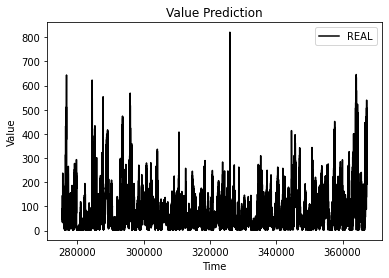

In [22]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

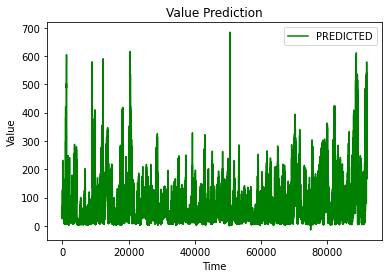

In [23]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [24]:
## Save Model
model.save('Models/pm25_model.h5')

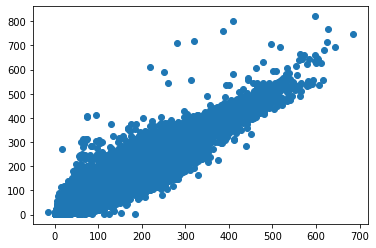

In [25]:
plt.scatter(y_predicted, y_real)

## Create Time Series Models for each variable

array([[<AxesSubplot:title={'center':'PM2.5'}>,
        <AxesSubplot:title={'center':'dt'}>,
        <AxesSubplot:title={'center':'PM10'}>],
       [<AxesSubplot:title={'center':'SO2'}>,
        <AxesSubplot:title={'center':'NO2'}>,
        <AxesSubplot:title={'center':'CO'}>],
       [<AxesSubplot:title={'center':'O3'}>,
        <AxesSubplot:title={'center':'TEMP'}>,
        <AxesSubplot:title={'center':'PRES'}>],
       [<AxesSubplot:title={'center':'DEWP'}>,
        <AxesSubplot:title={'center':'RAIN'}>, <AxesSubplot:>]],
      dtype=object)

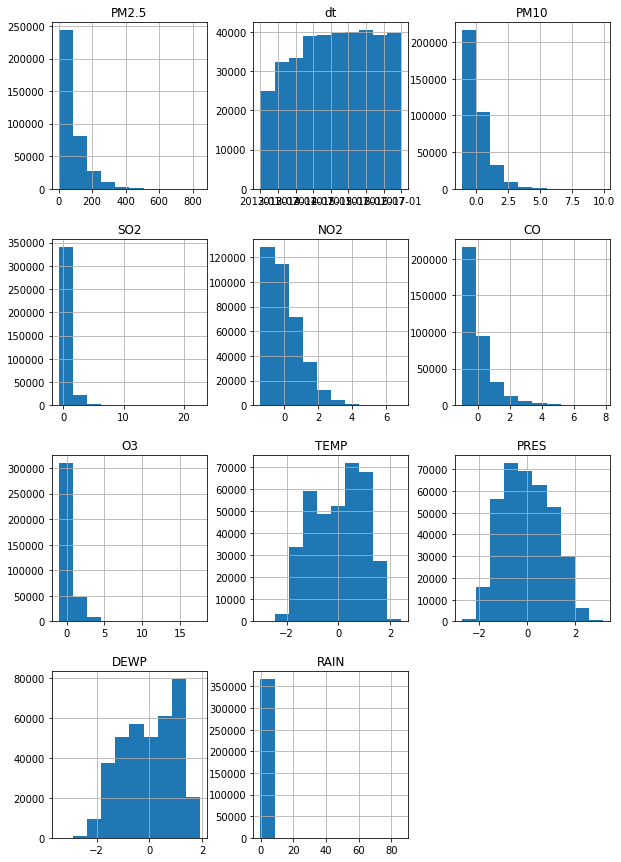

In [26]:
df.hist(figsize=(10, 15))

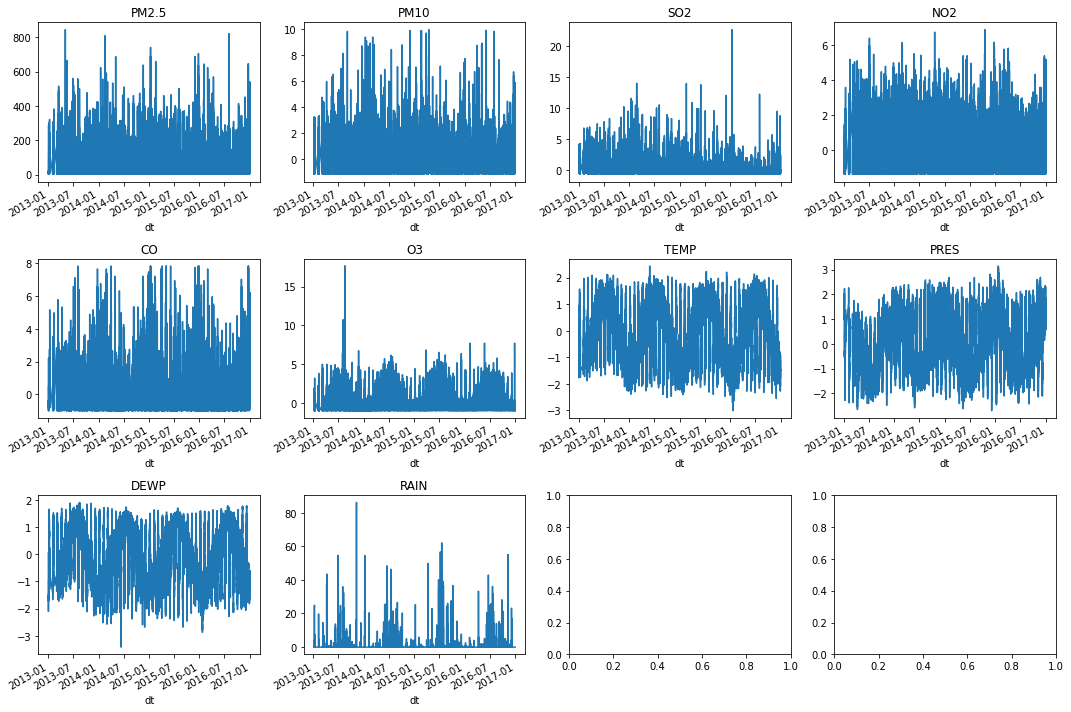

In [27]:
df=df.set_index(pd.to_datetime(df['dt']))
df = df.drop(columns = ['dt'])
fig, ax=plt.subplots(3, 4, figsize=(15, 10))

for idx, each_col in enumerate(df.columns): 
    if idx>=10: 
        break
    row_idx=idx//4
    col_idx=idx%4
    df[each_col].plot(ax=ax[row_idx][col_idx])
    ax[row_idx][col_idx].set_title(each_col)
plt.tight_layout()

In [28]:
df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN
dt,,,,,,,,,,
2013-01-03,4.0,-1.117062,-0.538590,-1.247505,-0.815927,0.330797,-1.309452,1.225754,-1.611258,-0.080522
2013-01-03,9.0,-1.061450,-0.585388,-0.959695,-0.815927,0.539777,-1.291730,1.370984,-1.802370,-0.080522
2013-01-03,4.0,-1.117062,-0.070608,-0.873352,-0.815927,0.191476,-1.309452,1.225754,-1.611258,-0.080522
2013-01-03,7.0,-1.083694,-0.585388,-1.391410,-0.994152,0.574608,-1.451230,0.964339,-1.750917,-0.080522
2013-01-03,5.0,-1.005838,-0.538590,-1.103600,-0.905040,0.470117,-1.291730,1.370984,-1.802370,-0.080522


<AxesSubplot:xlabel='dt'>

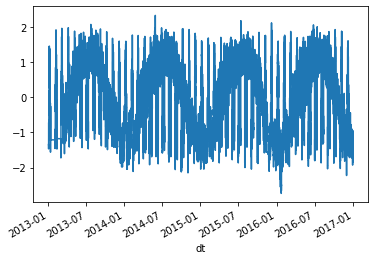

In [29]:
df['TEMP'].rolling(30).median().plot()

In [30]:
grouped_df=df.groupby('dt').mean()
grouped_df['TEMP'].head()

dt
2013-01-03 00:00:00   -1.325402
2013-01-03 01:00:00   -1.337020
2013-01-03 02:00:00   -1.403971
2013-01-03 03:00:00   -1.410469
2013-01-03 04:00:00   -1.447685
Name: TEMP, dtype: float64

### Create SO2 timeseries

In [31]:
import math
temp_arr=grouped_df['SO2'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(25068, 1)

In [32]:
test_arr.shape

(8355, 1)

In [33]:
days_season = 365
X_train = []
y_train = []
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [34]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(24703, 365, 1)

In [35]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(7990, 365, 1)

In [36]:
## So one big array with 365 smaller arrays within, each with 8000 or so individual single-value arrays within 

In [37]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 365, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [38]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
772/772 [==============================] - 202s 259ms/step - loss: 0.1117 - mean_squared_error: 0.1117
Epoch 2/5
772/772 [==============================] - 205s 266ms/step - loss: 0.0606 - mean_squared_error: 0.0606
Epoch 3/5
772/772 [==============================] - 194s 251ms/step - loss: 0.0595 - mean_squared_error: 0.0595
Epoch 4/5
772/772 [==============================] - 190s 246ms/step - loss: 0.0592 - mean_squared_error: 0.0592
Epoch 5/5
772/772 [==============================] - 199s 258ms/step - loss: 0.0587 - mean_squared_error: 0.0587


In [39]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

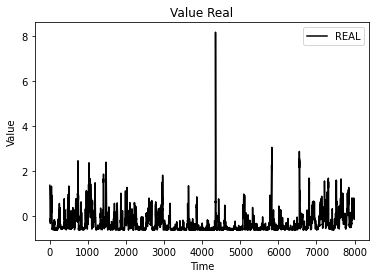

In [40]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Real')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

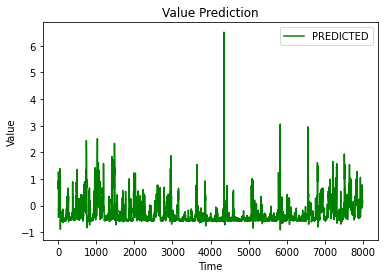

In [41]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [42]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
250/250 [==============================] - 60s 240ms/step - loss: 0.0220 - mean_squared_error: 0.0220
Epoch 2/2
250/250 [==============================] - 67s 267ms/step - loss: 0.0210 - mean_squared_error: 0.0210


In [43]:
## Save Model
lstm_model.save('Models/so3_model.h5')

### Create CO Time Series Model

In [44]:
temp_arr=grouped_df['CO'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(25068, 1)

In [45]:
test_arr.shape

(8355, 1)

In [46]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [47]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(24703, 365, 1)

In [48]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(7990, 365, 1)

In [49]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 365, 50)           10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [50]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
772/772 [==============================] - 190s 244ms/step - loss: 0.1091 - mean_squared_error: 0.1091
Epoch 2/5
772/772 [==============================] - 202s 261ms/step - loss: 0.0677 - mean_squared_error: 0.0677
Epoch 3/5
772/772 [==============================] - 192s 249ms/step - loss: 0.0650 - mean_squared_error: 0.0650
Epoch 4/5
772/772 [==============================] - 188s 243ms/step - loss: 0.0642 - mean_squared_error: 0.0642
Epoch 5/5
772/772 [==============================] - 193s 250ms/step - loss: 0.0627 - mean_squared_error: 0.0627


In [51]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

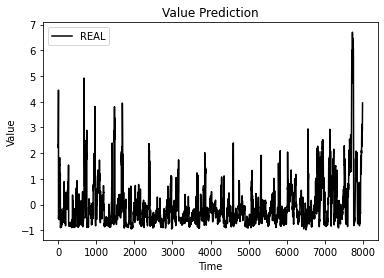

In [52]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

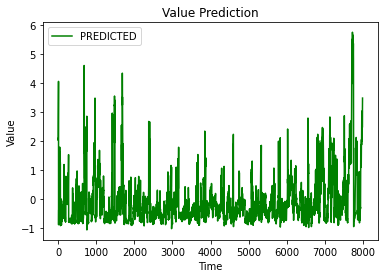

In [53]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [54]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
250/250 [==============================] - 59s 237ms/step - loss: 0.0452 - mean_squared_error: 0.0452
Epoch 2/2
250/250 [==============================] - 66s 265ms/step - loss: 0.0459 - mean_squared_error: 0.0459


In [55]:
## Save Model
lstm_model.save('Models/co_model.h5')

### Create DEWP Time Series Model

In [56]:
temp_arr=grouped_df['DEWP'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(25068, 1)

In [57]:
test_arr.shape

(8355, 1)

In [58]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [59]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(24703, 365, 1)

In [60]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(7990, 365, 1)

In [61]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 365, 50)           10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_8 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [62]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
772/772 [==============================] - 184s 235ms/step - loss: 0.0464 - mean_squared_error: 0.0464
Epoch 2/5
772/772 [==============================] - 196s 253ms/step - loss: 0.0202 - mean_squared_error: 0.0202
Epoch 3/5
772/772 [==============================] - 192s 248ms/step - loss: 0.0198 - mean_squared_error: 0.0198
Epoch 4/5
772/772 [==============================] - 180s 233ms/step - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 5/5
772/772 [==============================] - 193s 250ms/step - loss: 0.0194 - mean_squared_error: 0.0194


In [63]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

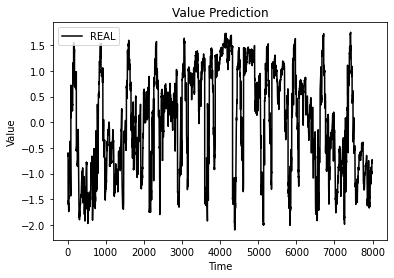

In [64]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

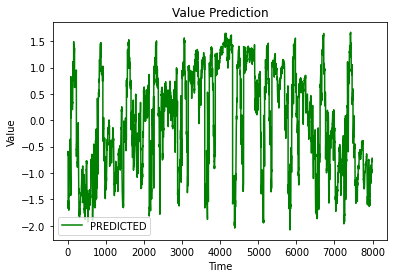

In [65]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [66]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
250/250 [==============================] - 60s 240ms/step - loss: 0.0210 - mean_squared_error: 0.0210
Epoch 2/2
250/250 [==============================] - 67s 269ms/step - loss: 0.0205 - mean_squared_error: 0.0205


In [67]:
## Save Model
lstm_model.save('Models/dewp_model.h5')

### Create NO2 Time Series Model

In [68]:
temp_arr=grouped_df['NO2'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(25068, 1)

In [69]:
test_arr.shape

(8355, 1)

In [70]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [71]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(24703, 365, 1)

In [72]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(7990, 365, 1)

In [73]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 365, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_10 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [74]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
772/772 [==============================] - 180s 230ms/step - loss: 0.0858 - mean_squared_error: 0.0858
Epoch 2/5
772/772 [==============================] - 187s 243ms/step - loss: 0.0558 - mean_squared_error: 0.0558
Epoch 3/5
772/772 [==============================] - 194s 251ms/step - loss: 0.0542 - mean_squared_error: 0.0542
Epoch 4/5
772/772 [==============================] - 179s 231ms/step - loss: 0.0540 - mean_squared_error: 0.0540
Epoch 5/5
772/772 [==============================] - 183s 237ms/step - loss: 0.0532 - mean_squared_error: 0.0532


In [75]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

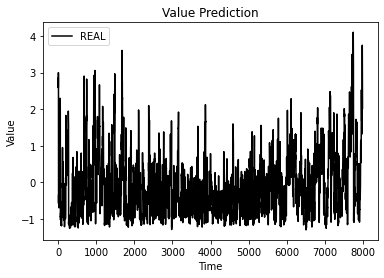

In [76]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

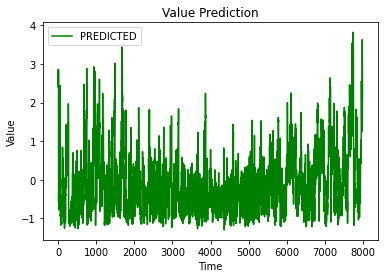

In [77]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [78]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
250/250 [==============================] - 62s 247ms/step - loss: 0.0450 - mean_squared_error: 0.0450
Epoch 2/2
250/250 [==============================] - 67s 268ms/step - loss: 0.0446 - mean_squared_error: 0.0446


In [79]:
## Save Model
lstm_model.save('Models/no2_model.h5')

### Create O3 time series model

In [80]:
temp_arr=grouped_df['O3'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(25068, 1)

In [81]:
test_arr.shape

(8355, 1)

In [82]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [83]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(24703, 365, 1)

In [84]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(7990, 365, 1)

In [85]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 365, 50)           10400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_12 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [86]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
772/772 [==============================] - 179s 229ms/step - loss: 0.0859 - mean_squared_error: 0.0859
Epoch 2/5
772/772 [==============================] - 184s 238ms/step - loss: 0.0320 - mean_squared_error: 0.0320
Epoch 3/5
772/772 [==============================] - 206s 267ms/step - loss: 0.0306 - mean_squared_error: 0.0306
Epoch 4/5
772/772 [==============================] - 184s 238ms/step - loss: 0.0303 - mean_squared_error: 0.0303
Epoch 5/5
772/772 [==============================] - 190s 246ms/step - loss: 0.0299 - mean_squared_error: 0.0299


In [87]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

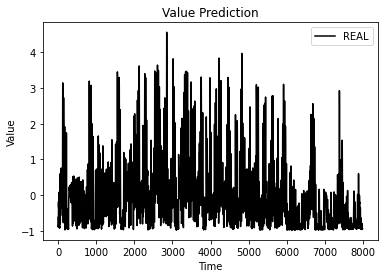

In [88]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

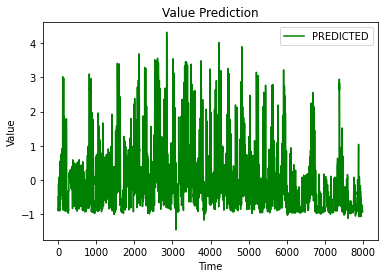

In [89]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [90]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
250/250 [==============================] - 66s 263ms/step - loss: 0.0239 - mean_squared_error: 0.0239
Epoch 2/2
250/250 [==============================] - 56s 223ms/step - loss: 0.0243 - mean_squared_error: 0.0243


In [91]:
## Save Model
lstm_model.save('Models/o3_model.h5')

### Create pm10 time series model

In [92]:
temp_arr=grouped_df['PM10'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(25068, 1)

In [93]:
test_arr.shape

(8355, 1)

In [94]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [95]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(24703, 365, 1)

In [96]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(7990, 365, 1)

In [97]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 365, 50)           10400     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_14 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [98]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
772/772 [==============================] - 193s 247ms/step - loss: 0.1191 - mean_squared_error: 0.1191
Epoch 2/5
772/772 [==============================] - 177s 230ms/step - loss: 0.0736 - mean_squared_error: 0.0736
Epoch 3/5
772/772 [==============================] - 188s 244ms/step - loss: 0.0731 - mean_squared_error: 0.0731
Epoch 4/5
772/772 [==============================] - 191s 247ms/step - loss: 0.0721 - mean_squared_error: 0.0721
Epoch 5/5
772/772 [==============================] - 178s 231ms/step - loss: 0.0723 - mean_squared_error: 0.0723


In [99]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

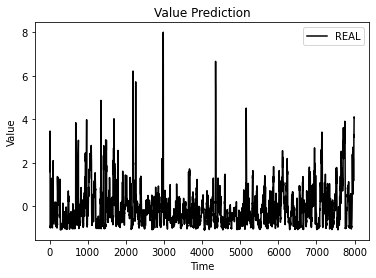

In [100]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

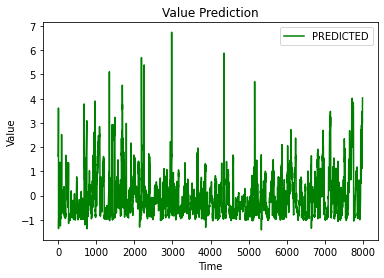

In [101]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [102]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
250/250 [==============================] - 62s 249ms/step - loss: 0.0731 - mean_squared_error: 0.0731
Epoch 2/2
250/250 [==============================] - 55s 218ms/step - loss: 0.0746 - mean_squared_error: 0.0746


In [103]:
## Save Model
lstm_model.save('Models/pm10_model.h5')

### Create PRES time series model

In [104]:
temp_arr=grouped_df['PRES'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(25068, 1)

In [105]:
test_arr.shape

(8355, 1)

In [106]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [107]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(24703, 365, 1)

In [108]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(7990, 365, 1)

In [109]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 365, 50)           10400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_16 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [110]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
772/772 [==============================] - 195s 250ms/step - loss: 0.0446 - mean_squared_error: 0.0446
Epoch 2/5
772/772 [==============================] - 179s 232ms/step - loss: 0.0218 - mean_squared_error: 0.0218
Epoch 3/5
772/772 [==============================] - 182s 236ms/step - loss: 0.0213 - mean_squared_error: 0.0213
Epoch 4/5
772/772 [==============================] - 191s 248ms/step - loss: 0.0214 - mean_squared_error: 0.0214
Epoch 5/5
772/772 [==============================] - 189s 244ms/step - loss: 0.0210 - mean_squared_error: 0.0210


In [111]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

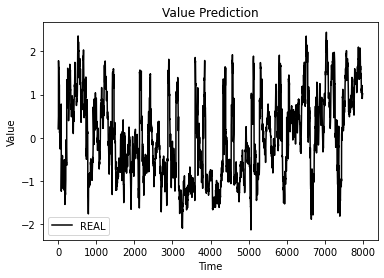

In [112]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

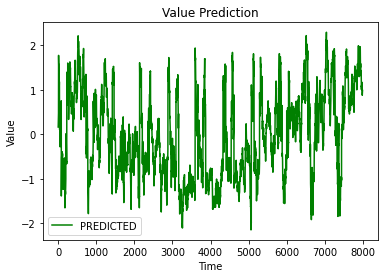

In [113]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [114]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
250/250 [==============================] - 56s 223ms/step - loss: 0.0217 - mean_squared_error: 0.0217
Epoch 2/2
250/250 [==============================] - 55s 221ms/step - loss: 0.0217 - mean_squared_error: 0.0217


In [115]:
## Save Model
lstm_model.save('Models/pres_model.h5')

### Create TEMP time series model

In [116]:
temp_arr=grouped_df['TEMP'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(25068, 1)

In [117]:
test_arr.shape

(8355, 1)

In [118]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [119]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(24703, 365, 1)

In [120]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(7990, 365, 1)

In [121]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 365, 50)           10400     
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_18 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [122]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
772/772 [==============================] - 192s 246ms/step - loss: 0.0461 - mean_squared_error: 0.0461
Epoch 2/5
772/772 [==============================] - 186s 241ms/step - loss: 0.0171 - mean_squared_error: 0.0171
Epoch 3/5
772/772 [==============================] - 185s 240ms/step - loss: 0.0160 - mean_squared_error: 0.0160
Epoch 4/5
772/772 [==============================] - 187s 242ms/step - loss: 0.0159 - mean_squared_error: 0.0159
Epoch 5/5
772/772 [==============================] - 188s 244ms/step - loss: 0.0158 - mean_squared_error: 0.0158


In [123]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

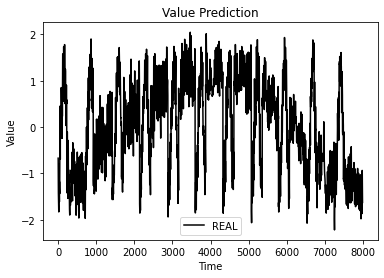

In [124]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

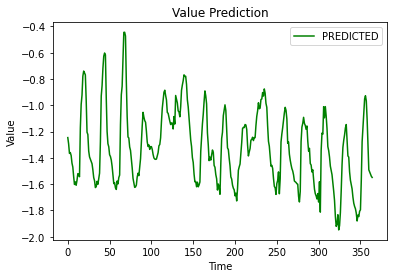

In [125]:
plt.plot(y_predicted[-365:], color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [126]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
250/250 [==============================] - 56s 224ms/step - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 2/2
250/250 [==============================] - 57s 228ms/step - loss: 0.0184 - mean_squared_error: 0.0184


In [127]:
## Save Model
lstm_model.save('Models/temp_model.h5')

### Create RAIN time series model

In [128]:
temp_arr=grouped_df['RAIN'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(25068, 1)

In [129]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [130]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(24703, 365, 1)

In [131]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(7990, 365, 1)

In [132]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 365, 50)           10400     
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_20 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [133]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
772/772 [==============================] - 197s 252ms/step - loss: 0.3491 - mean_squared_error: 0.3491
Epoch 2/5
772/772 [==============================] - 194s 252ms/step - loss: 0.3205 - mean_squared_error: 0.3205
Epoch 3/5
772/772 [==============================] - 187s 242ms/step - loss: 0.3194 - mean_squared_error: 0.3194
Epoch 4/5
772/772 [==============================] - 185s 240ms/step - loss: 0.3154 - mean_squared_error: 0.3154
Epoch 5/5
772/772 [==============================] - 194s 251ms/step - loss: 0.3139 - mean_squared_error: 0.3139


In [134]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

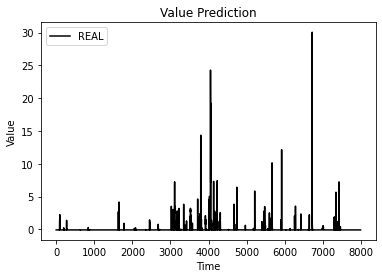

In [135]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

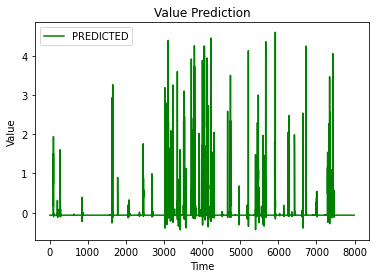

In [136]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [137]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
250/250 [==============================] - 59s 235ms/step - loss: 0.5130 - mean_squared_error: 0.5130
Epoch 2/2
250/250 [==============================] - 67s 269ms/step - loss: 0.4491 - mean_squared_error: 0.4491


In [138]:
## Save Model
lstm_model.save('Models/rain_model.h5')